In [305]:
# importamos las librerías que necesitamos
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Imputación de nulos usando métodos avanzados estadísticos
# -----------------------------------------------------------------------
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

# Librerías de visualización
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
# Configuración
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None) # para poder visualizar todas las columnas de los DataFrames

In [306]:
df = pd.read_csv("data/finanzas_hotel_bookings.csv", index_col=0, low_memory=False)

In [307]:
# Eliminamos ultimas filas que tienen en su mayoría valores nulos y no sirven para el análisis
df = df.iloc[:119390]

In [308]:
df.drop("0", axis = 1, inplace = True) # Elimina la COLUMNA y sobreescribe los cambios

In [309]:
def convertir_a_boleano(df, columnas):
    """
    Convierte las columnas especificadas de un DataFrame a tipo booleano.

    Parámetros:
    df (pandas.DataFrame): El DataFrame en el que se encuentran las columnas.
    columnas (list): Lista de nombres de columnas a convertir.

    Retorna:
    pandas.DataFrame: El DataFrame con las columnas convertidas a booleano.
    """
    print(f'El tipo de dato antes del cambio \n {df["is_repeated_guest"].dtype} \n {df["is_canceled"].dtype}')
    
    for columna in columnas:
        df[columna] = df[columna].astype(bool)
    print(f'El tipo de dato después del cambio \n {df["is_repeated_guest"].dtype} \n {df["is_canceled"].dtype}')
    return df

columnas = ["is_repeated_guest", "is_canceled"]
df = convertir_a_boleano(df, columnas)


# Convierte los valores de la columna a positivos
df['adr'] = df['adr'].abs()

El tipo de dato antes del cambio 
 float64 
 object
El tipo de dato después del cambio 
 bool 
 bool


In [310]:
# →  Estandarizar para que en todos los casos sean números y cambiar el datatype de la columna a número entero.

def cambiar_formato_mes(df):
    # Diccionario de mapeo de meses y valores numéricos
    dic_map = {
        'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 
        'June': 6, 'July': 7, 'August': 8, 'September': 9, 'October': 10, 
        'November': 11, 'December': 12, 
        1: 1, 2: 2, 3: 3, 4:4, 5:5, 6:6, 7:7, 8:8, 9:9, 10:10, 11:11, 12:12, 'nan': np.nan}
    
    # Asegurarse de que los valores en la columna sean de tipo string para mapear correctamente
    df['arrival_date_month'] = df['arrival_date_month'].astype(str).map(dic_map).astype('Int64')

    return df

df = cambiar_formato_mes(df)

In [311]:
def rellenar_año_llegada(df):  

    print(f'nulos antes de hacer la operación {df["arrival_date_year"].isna().sum()}')

    # Asegúrate de que las columnas de fecha estén en formato datetime
    df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'], errors='coerce')

    # Crear una columna para el total de la estancia
    df['total_stays'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']

    # Inicializar la columna de fecha de llegada estimada con valores NaT (Not a Time)
    df['estimated_arrival_date'] = pd.NaT

    # Crear filtro para cuando el estado de la reserva es "Checkout"
    filtro_checkout = df['reservation_status'] == 'Checkout'

    # Calcular fecha de llegada estimada solo para "Checkout"
    df.loc[filtro_checkout, 'estimated_arrival_date'] = df.loc[filtro_checkout, 'reservation_status_date'] - pd.to_timedelta(df.loc[filtro_checkout, 'total_stays'], unit='D')

    # Extraer el año de la fecha de llegada estimada
    df['estimated_arrival_year'] = df['estimated_arrival_date'].dt.year

    # Para los que no son "Checkout", usar el año de la fecha de estado de reserva
    df.loc[~filtro_checkout, 'estimated_arrival_year'] = df.loc[~filtro_checkout, 'reservation_status_date'].dt.year

    # Rellenar los valores nulos en arrival_date_year con el año estimado
    df['arrival_date_year'] = df['arrival_date_year'].fillna(df['estimated_arrival_year'])

    print(f'nulos después de hacer la operación {df["arrival_date_year"].isna().sum()}')

    return df

df = rellenar_año_llegada(df)

nulos antes de hacer la operación 54561
nulos después de hacer la operación 5936


In [312]:
# 1.Reemplazar los nulos con "0000-00-00"

def imputar_fechas_nulas(df, columns):
        """ Dada una lista de columnas y un dataframe, esta función completa los nulos en las columnas con "0000-00-00".
        """
        # Iterar sobre la lista de columnas y reemplazar nulos por "0000-00-00"
        for column in columns:
            # verifica si la columna existe en el dataframe
            if column in df.columns:
                # Reemplaza los nulos con "0000-00-00"
                df[column] = df[column].fillna("0000-00-00")
            # si la columna no existe imprime un mensaje
            else:
                print(f"❌ La columna '{column}' no existe en el dataframe dado")
        return df

columns = ['reservation_status_date']
df = imputar_fechas_nulas(df, columns)

In [313]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,total_stays,estimated_arrival_date,estimated_arrival_year
0,Resort Hotel,False,342.0,2015.0,7,27.0,1.0,0.0,0.0,2.0,NaN,0.0,BB,PRT,NaN,Direct,False,NaN,0.0,C,C,3.0,NaN,NaN,0.0,Transient,0.0,0.0,0.0,Check-Out,2015-07-01 00:00:00,0.0,NaT,2015.0
1,Resort Hotel,False,737.0,2015.0,7,27.0,1.0,0.0,0.0,2.0,NaN,0.0,BB,NaN,NaN,Direct,False,0.0,0.0,NaN,C,4.0,NaN,NaN,0.0,Transient,0.0,0.0,0.0,Check-Out,2015-07-01 00:00:00,0.0,NaT,2015.0
2,Resort Hotel,False,7.0,2015.0,7,27.0,1.0,0.0,1.0,1.0,0.0,0.0,BB,GBR,NaN,Direct,False,0.0,0.0,A,C,0.0,NaN,NaN,0.0,Transient,75.0,0.0,0.0,Check-Out,2015-07-02 00:00:00,1.0,NaT,2015.0
3,Resort Hotel,False,13.0,2015.0,7,27.0,1.0,0.0,1.0,1.0,NaN,0.0,BB,GBR,Corporate,Corporate,False,0.0,0.0,A,A,0.0,304.0,NaN,0.0,Transient,75.0,0.0,0.0,Check-Out,2015-07-02 00:00:00,1.0,NaT,2015.0
4,Resort Hotel,False,14.0,2015.0,7,NaN,1.0,0.0,2.0,2.0,NaN,0.0,BB,NaN,Online TA,TA/TO,False,0.0,0.0,A,A,0.0,240.0,NaN,0.0,Transient,98.0,0.0,1.0,Check-Out,2015-07-03 00:00:00,2.0,NaT,2015.0


In [314]:
df["adults"].value_counts()

2.0     82156
1.0     21094
3.0      5716
59.0     1035
54.0     1025
51.0     1011
58.0     1005
50.0      999
57.0      998
53.0      984
56.0      975
55.0      959
52.0      936
0.0       369
4.0        53
19.0       13
14.0       10
12.0        7
10.0        7
11.0        6
15.0        5
26.0        5
18.0        5
16.0        5
13.0        4
27.0        2
5.0         2
20.0        2
6.0         1
17.0        1
Name: adults, dtype: int64

Vemos que hay un número muy elevado de adultos en una misma habitación. Vamos a ver si esa habitación corresponde siempre al mismo tipo y sacar conclusiones de que pueda ser un salón de actos, comedor, sala de juntas, etc. 

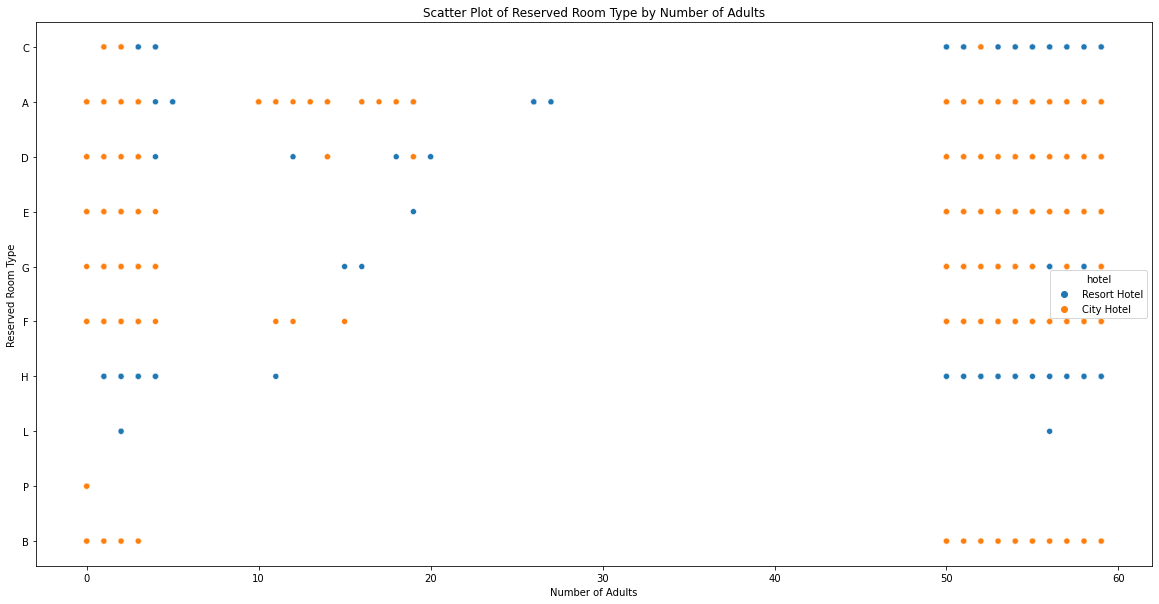

In [315]:
# Graficar la relación entre el número de adultos y el tipo de habitación reservada
plt.figure(figsize=(20, 10))
sns.scatterplot(x='adults', 
                y='reserved_room_type',
                data=df, hue='hotel')
plt.xlabel('Number of Adults')
plt.ylabel('Reserved Room Type')
plt.title('Scatter Plot of Reserved Room Type by Number of Adults')
plt.show()

Text(0.5, 1.0, 'Número de Adultos por Tipo de Habitación')

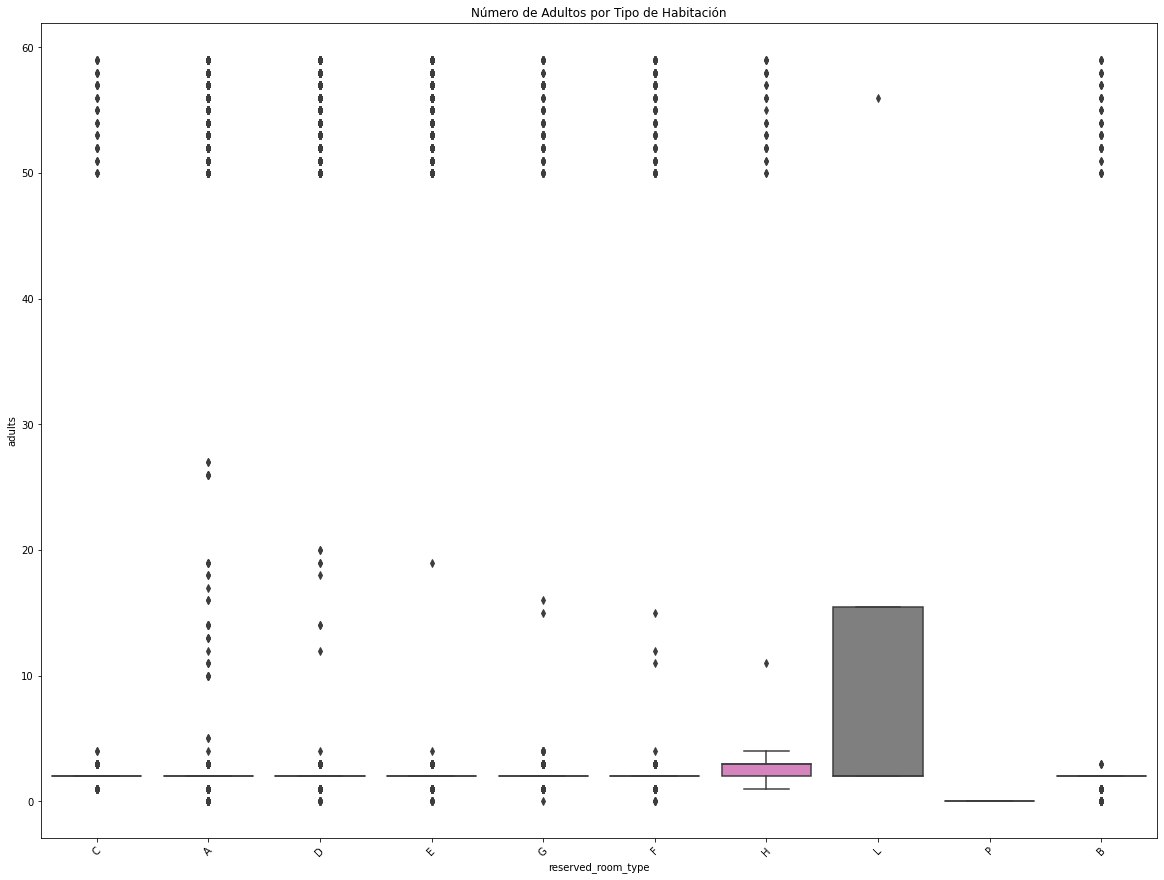

In [316]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 15))
# Relación entre el tipo de habitación y el número de adultos
sns.boxplot(x='reserved_room_type', y='adults', data=df)
plt.xticks(rotation=45)
plt.title('Número de Adultos por Tipo de Habitación')

In [317]:
df["children"].value_counts()

0.0     64221
1.0      2797
2.0      2138
3.0        45
18.0       12
14.0       12
10.0        9
11.0        8
15.0        7
17.0        5
13.0        5
16.0        5
19.0        3
12.0        3
Name: children, dtype: int64

Vemmos que hay un número muy elevado de niños en una misma habitación, que pasa de 3 a más de 10

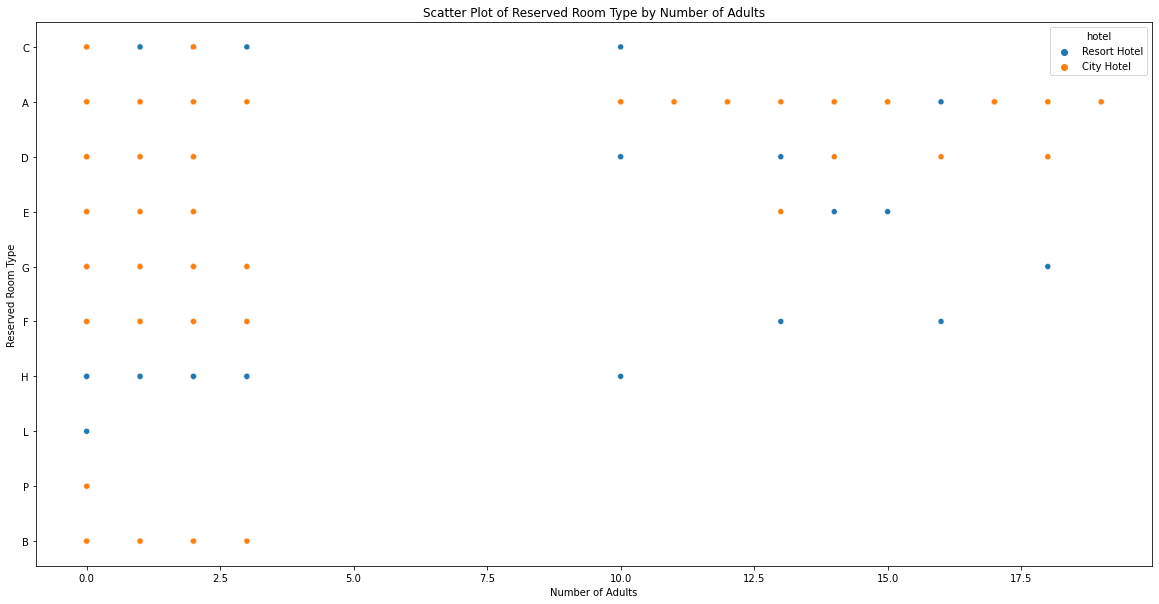

In [318]:
# Graficar la relación entre el número de adultos y el tipo de habitación reservada
plt.figure(figsize=(20, 10))
sns.scatterplot(x='children', 
                y='reserved_room_type',
                data=df, hue='hotel')
plt.xlabel('Number of Adults')
plt.ylabel('Reserved Room Type')
plt.title('Scatter Plot of Reserved Room Type by Number of Adults')
plt.show()

Text(0.5, 1.0, 'Número de Niños por Tipo de Habitación')

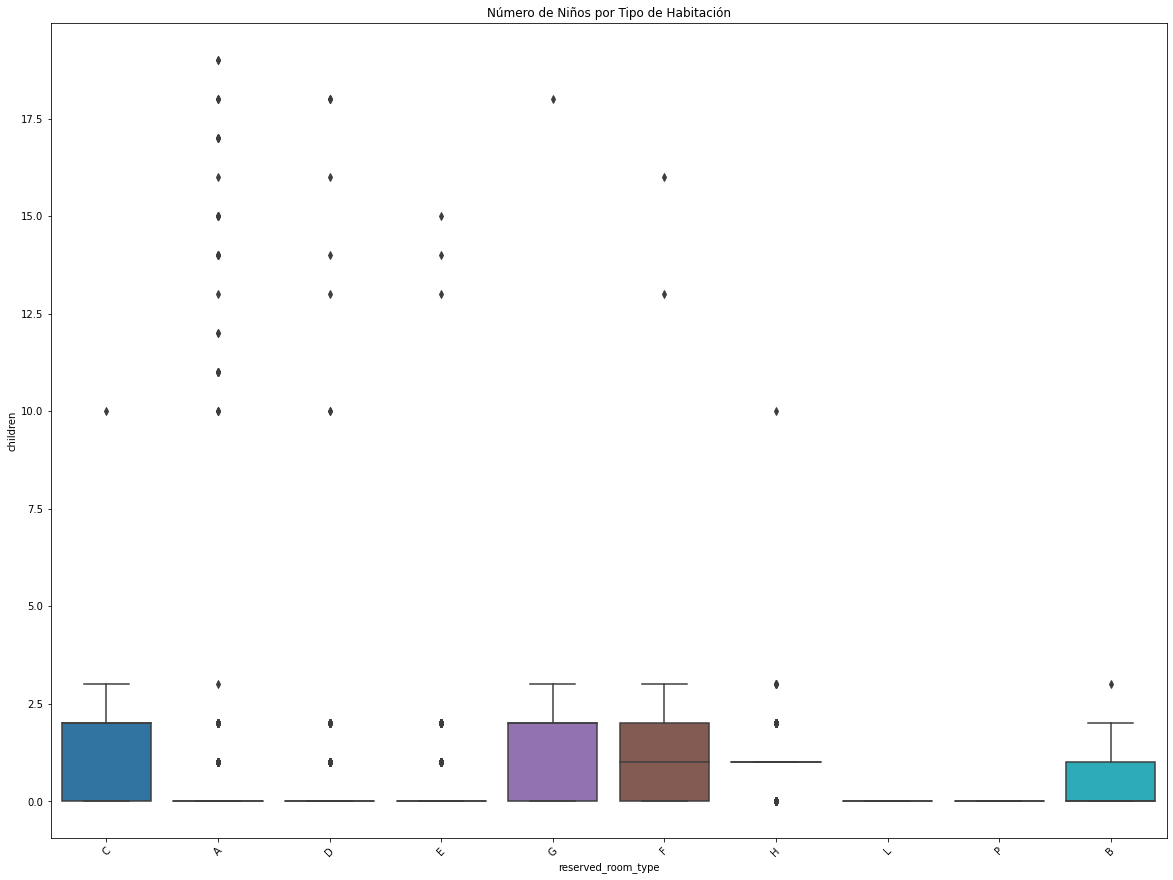

In [319]:
plt.figure(figsize=(20, 15))
# Relación entre el tipo de habitación y el número de niños
sns.boxplot(x='reserved_room_type', y='children', data=df)
plt.xticks(rotation=45)
plt.title('Número de Niños por Tipo de Habitación')

In [320]:
df["babies"].value_counts()

0.0     118414
1.0        900
2.0         15
16.0        11
12.0        11
10.0        11
19.0         7
18.0         5
15.0         4
11.0         4
17.0         3
13.0         3
9.0          1
14.0         1
Name: babies, dtype: int64

Vemos que hay un número muy elevado de bebes en la misma habitación. Pasando de 2 a más de 9

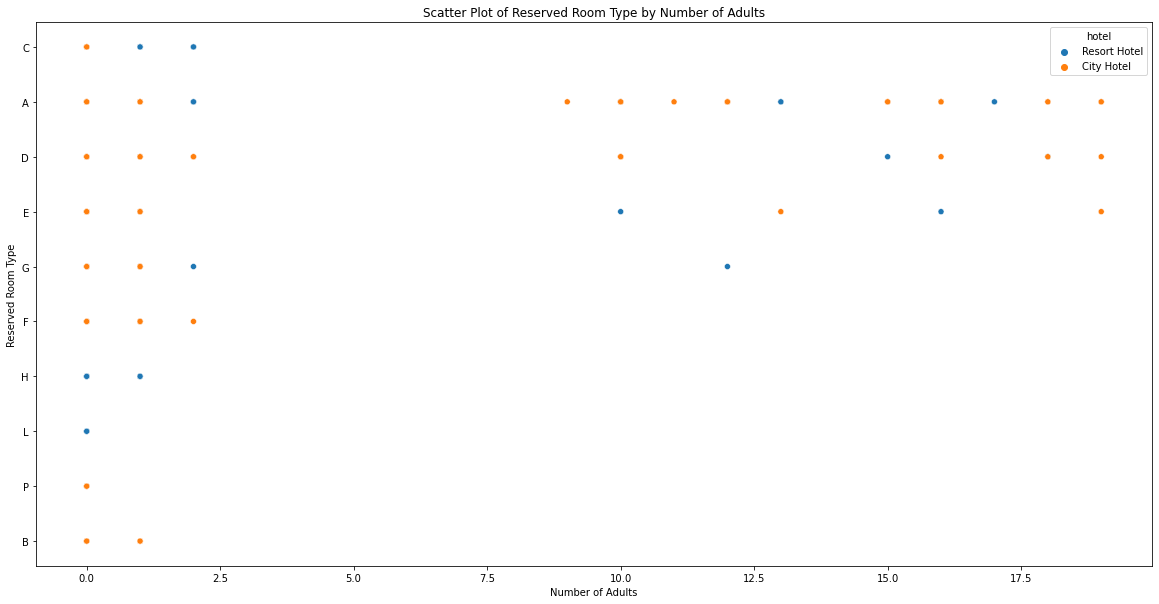

In [321]:
# Graficar la relación entre el número de adultos y el tipo de habitación reservada
plt.figure(figsize=(20, 10))
sns.scatterplot(x='babies', 
                y='reserved_room_type',
                data=df, hue='hotel')
plt.xlabel('Number of Adults')
plt.ylabel('Reserved Room Type')
plt.title('Scatter Plot of Reserved Room Type by Number of Adults')
plt.show()

Text(0.5, 1.0, 'Número de Bebés por Tipo de Habitación')

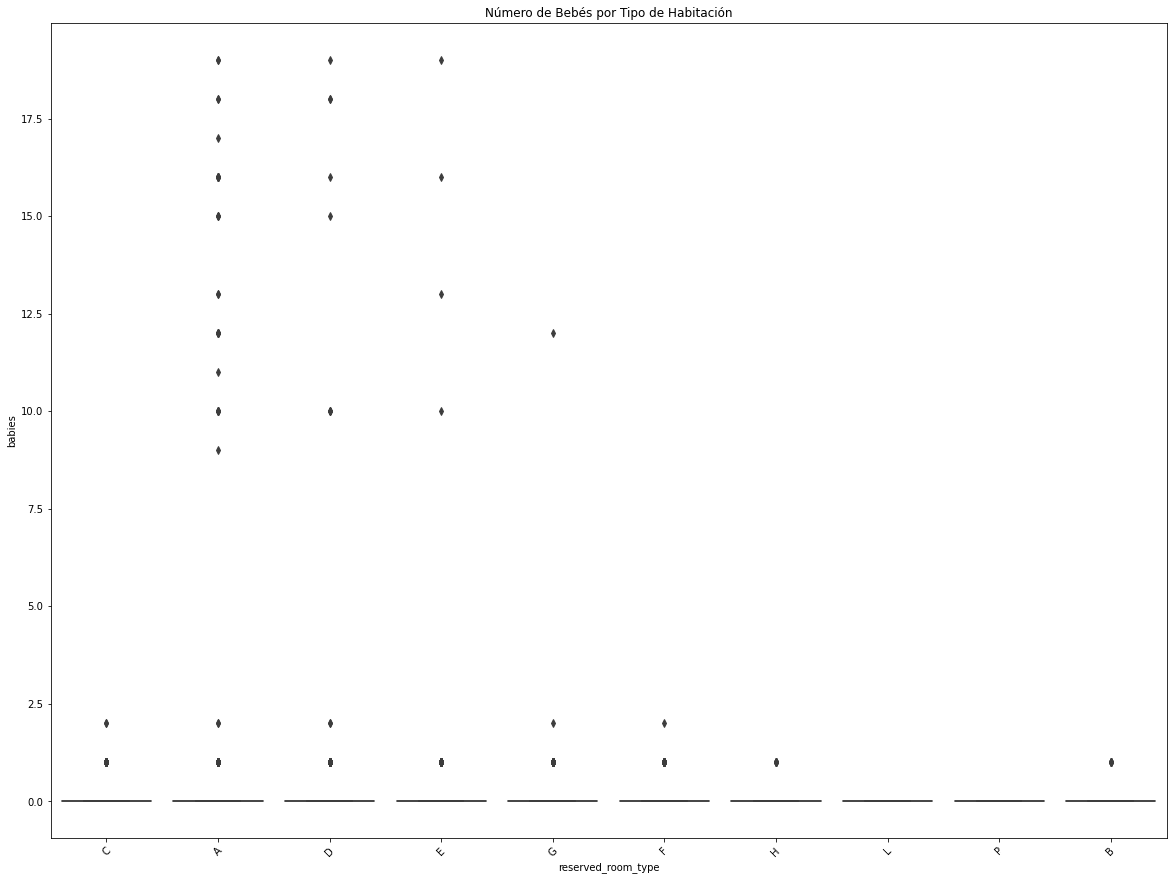

In [322]:
plt.figure(figsize=(20, 15))
# Relación entre el tipo de habitación y el número de bebés
sns.boxplot(x='reserved_room_type', y='babies', data=df)
plt.xticks(rotation=45)
plt.title('Número de Bebés por Tipo de Habitación')

In [323]:
df_mas_de30_adultos = df[df["adults"]>30]

In [324]:
df_mas_de30_adultos.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,total_stays,estimated_arrival_date,estimated_arrival_year
23,Resort Hotel,False,72.0,2015.0,7,NaN,1.0,2.0,4.0,51.0,0.0,0.0,BB,NaN,Direct,Direct,False,0.0,0.0,D,D,1.0,250.0,NaN,0.0,Transient,99.67,0.0,1.0,Check-Out,2015-07-07 00:00:00,6.0,NaT,2015.0
41,Resort Hotel,False,45.0,2015.0,7,27.0,2.0,2.0,3.0,52.0,NaN,0.0,BB,NaN,NaN,TA/TO,False,NaN,0.0,NaN,D,0.0,8.0,NaN,0.0,Contract,79.50,0.0,0.0,Check-Out,2015-07-07 00:00:00,5.0,NaT,2015.0
69,Resort Hotel,True,63.0,2015.0,7,27.0,3.0,0.0,2.0,53.0,NaN,0.0,BB,PRT,Online TA,TA/TO,False,NaN,0.0,NaN,A,0.0,240.0,NaN,0.0,Transient,82.00,0.0,2.0,Canceled,2015-06-18 00:00:00,2.0,NaT,2015.0
86,Resort Hotel,False,69.0,2015.0,7,27.0,3.0,4.0,10.0,55.0,0.0,0.0,BB,NaN,NaN,TA/TO,False,NaN,0.0,F,F,1.0,241.0,NaN,0.0,NaN,92.45,0.0,1.0,Check-Out,2015-07-17 00:00:00,14.0,NaT,2015.0
92,Resort Hotel,False,9.0,2015.0,7,27.0,3.0,0.0,1.0,57.0,0.0,0.0,BB,USA,Online TA,TA/TO,False,0.0,0.0,C,C,0.0,241.0,NaN,0.0,NaN,94.71,0.0,0.0,Check-Out,2015-07-04 00:00:00,1.0,NaT,2015.0


In [325]:
df_mas_de30_adultos["customer_type"].value_counts()

Transient          5815
Transient-Party    1670
Contract            257
Group                41
Name: customer_type, dtype: int64

No se ve ningún patrón que explique un número elevado de adultos en la habitación

In [326]:
df_children_nan = df[df['children'].isna()]

In [327]:
df_children_nan.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,total_stays,estimated_arrival_date,estimated_arrival_year
0,Resort Hotel,False,342.0,2015.0,7,27.0,1.0,0.0,0.0,2.0,NaN,0.0,BB,PRT,NaN,Direct,False,NaN,0.0,C,C,3.0,NaN,NaN,0.0,Transient,0.0,0.0,0.0,Check-Out,2015-07-01 00:00:00,0.0,NaT,2015.0
1,Resort Hotel,False,737.0,2015.0,7,27.0,1.0,0.0,0.0,2.0,NaN,0.0,BB,NaN,NaN,Direct,False,0.0,0.0,NaN,C,4.0,NaN,NaN,0.0,Transient,0.0,0.0,0.0,Check-Out,2015-07-01 00:00:00,0.0,NaT,2015.0
3,Resort Hotel,False,13.0,2015.0,7,27.0,1.0,0.0,1.0,1.0,NaN,0.0,BB,GBR,Corporate,Corporate,False,0.0,0.0,A,A,0.0,304.0,NaN,0.0,Transient,75.0,0.0,0.0,Check-Out,2015-07-02 00:00:00,1.0,NaT,2015.0
4,Resort Hotel,False,14.0,2015.0,7,NaN,1.0,0.0,2.0,2.0,NaN,0.0,BB,NaN,Online TA,TA/TO,False,0.0,0.0,A,A,0.0,240.0,NaN,0.0,Transient,98.0,0.0,1.0,Check-Out,2015-07-03 00:00:00,2.0,NaT,2015.0
5,Resort Hotel,False,14.0,2015.0,7,27.0,1.0,0.0,2.0,2.0,NaN,0.0,BB,GBR,Online TA,TA/TO,False,0.0,0.0,A,A,0.0,240.0,NaN,0.0,NaN,98.0,0.0,1.0,Check-Out,2015-07-03 00:00:00,2.0,NaT,2015.0


In [328]:
df_children_nan.describe()

,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,total_stays,estimated_arrival_year
count,50120.000000,47614.000000,46220.000000,42379.000000,50069.000000,50120.000000,50120.000000,50120.000000,0.0,50120.000000,32033.000000,50120.000000,50120.000000,43320.000000,1643.000000,50120.000000,50120.000000,50120.000000,50120.000000,50120.000000,44777.000000
mean,104.116500,2016.126496,6.940632,27.222209,15.786395,0.932542,2.510036,6.224800,NaN,0.015323,0.102550,0.135196,0.231325,86.589058,187.767498,2.330088,101.612660,0.061453,0.570231,3.442578,2016.093329
std,106.924039,0.711528,2.924884,13.634005,8.782130,1.011091,1.945326,14.552246,NaN,0.349105,0.965245,1.516037,0.761905,110.879777,131.590887,17.461140,48.072237,0.241569,0.790625,2.613679,0.714881
min,0.000000,2014.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2014.000000
25%,18.000000,2016.000000,5.000000,16.000000,8.000000,0.000000,1.000000,2.000000,NaN,0.000000,0.000000,0.000000,0.000000,9.000000,60.500000,0.000000,69.000000,0.000000,0.000000,2.000000,2016.000000
50%,69.000000,2016.000000,7.000000,28.000000,16.000000,1.000000,2.000000,2.000000,NaN,0.000000,0.000000,0.000000,0.000000,14.000000,178.000000,0.000000,94.950000,0.000000,0.000000,3.000000,2016.000000
75%,161.000000,2017.000000,9.000000,38.000000,24.000000,2.000000,3.000000,2.000000,NaN,0.000000,0.000000,0.000000,0.000000,229.000000,272.000000,0.000000,126.000000,0.000000,1.000000,4.000000,2017.000000
max,737.000000,2017.000000,12.000000,53.000000,31.000000,19.000000,50.000000,59.000000,NaN,19.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,508.000000,3.000000,5.000000,69.000000,2017.000000


In [329]:
df_children_nan.describe(include='O')

,hotel,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,customer_type,reservation_status,reservation_status_date
count,50120,50120,27405,24974,44412,33239,50120,39520,50120,50120
unique,2,5,137,8,5,10,12,4,3,920
top,City Hotel,BB,PRT,Online TA,TA/TO,A,A,Transient,Check-Out,0000-00-00
freq,33270,38592,11176,11763,36465,23950,31074,29521,31524,5343
